<a href="https://colab.research.google.com/github/antoszy/interview/blob/main/face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Opis zadania

Należy przygotować funkcję rozpoznawania twarzy na podanych zdjęciach. \
Funkcja powinna przyjmować na wejściu zdjęcie, a zwracać zdjęcia z oznaczonymi innym kolorem twarzami, oraz liczbę rozpoznanych twarzy. 

## Import modułów

In [ ]:
!pip3 install -q face_recognition PyStasm
import face_recognition as face_rec
from google.colab import drive
from os import chdir
from pathlib import Path
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import stasm

##Funkcje pomocnicze

In [ ]:
def display_img(img:np.ndarray, tgt_width:int = None):
  if tgt_width is not None:
    scale = tgt_width / img.shape[1]
    tgt_height = int(img.shape[0] * scale)
    cv2_imshow(cv2.resize(img, (tgt_width, tgt_height)))
  else:
    cv2_imshow(img)

## Wczytanie obrazów
Obrazki są wczytywane z katologu znajdującego się na `My Drive`. Aby umożliwić dostep do `My Drive` należy uruchomić skrypt, przejść do linku który pojawi się w polu poniżej, wyrazić zgodę i przekopowiać wygenerowane hasło do formulaża poniżej. Zdjęcia najlepiej umieścić w katalogu: `zadanie_rekrutacyjne_cv/img`. W przeciwnym razie należy zmodyfikować parametr `IMG_ABS_PATH`.

In [ ]:
IMG_ABS_PATH = "/content/drive/My Drive/zadanie_rekrutacyjne_cv/img"

drive.mount("/content/drive/", force_remount=True)
img_paths = Path(IMG_ABS_PATH).glob("*")
imgs = [cv2.imread(str(img_path)) for img_path in img_paths if img_path.suffix in (".png", ".jpeg")]
print(f"{len(imgs)} images loaded.")

Mounted at /content/drive/
3 images loaded.


## Podgląd obrazów

Image resolution: (1333, 2000)


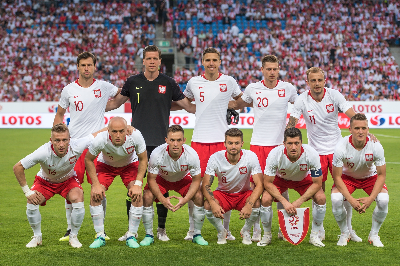

Image resolution: (1733, 2600)


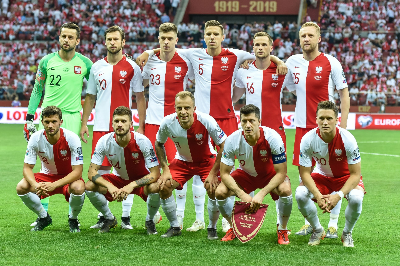

Image resolution: (766, 1170)


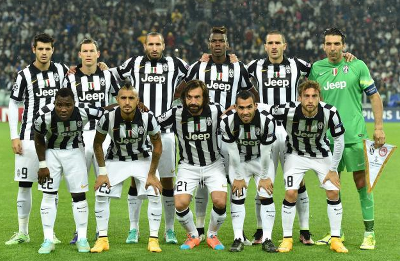

In [ ]:
for img in imgs:
  print(f"Image resolution: {img.shape[0:2]}")
  display_img(img, tgt_width=400)

## Funkcja przetwarzania obrazów
Wykożystano 2 hiperparametry:
1. `MIN_FACE_WIDTH` - minimalna wielkość twarzy wymagana do poprawnego wykrycia twarzy przez biblitekę PyStasm
1. `FACE_BBOX_EXTENTION_RATIO` - jak bardzo bbox otaczający twarz powinien być rozszerzony by obejmować cała głowę

In [ ]:
MIN_FACE_WIDTH = 200
FACE_BBOX_EXTENTION_RATIO = 2.0


def min_max_cord(x1:int, x2:int) -> (int, int):
  """ Takes 2 coordinates and resturns minimum and maximum coordinate"""
  return min(x1,x2), max(x1,x2)

  
def extend_bbox(x_min:int, x_max:int, y_min:int, y_max:int, img_shape, extension_ratio=1.5):
  """
  Extends bounding box by a given extension_ratio. extension_ration = 1.0 is
  a neutral operation. The extended bounding box is clipped to fit in
  the original image.
  """
  width = x_max - x_min
  height = y_max - y_min
  x_extension = width * (extension_ratio-1.0) / 2
  y_extension = height * (extension_ratio-1.0) / 2
  #Clip to image shape and return
  return [int(max(x_min - x_extension, 0)),
          int(min(x_max + x_extension, img_shape[1])),
          int(max(y_min - y_extension, 0)),
          int(min(y_max + y_extension, img_shape[0]))]


def scale_img(img:np.ndarray, ratio:float=2.0) -> np.ndarray:
  """
  Scales image by a given ratio. ratio=1.0 is a nutral opration.
  """
  dim = tuple([int(d*ratio) for d in img.shape])
  return cv2.resize(img, dim)


def scale_points(points_arr:np.ndarray, scale:float) -> np.ndarray:
  """
  Scales array of points by a chosen scale.
  """
  return (points_arr*scale).astype(np.int)


def count_and_color_faces(img:np.ndarray, draw_bboxes:bool = False) -> (int, np.ndarray):
  """
  Changes color of faces in the image to green. Returns number of colored faces
  and colored image.
  """
  faces_locs = face_rec.face_locations(img) #finds face bounding boxes
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #stasm library uses grayscale image
  mod_img = np.copy(img)
  face_number = 0
  for bbox in faces_locs:
    y2,x2,y1,x1 = bbox
    x_min, x_max = min_max_cord(x1, x2)
    y_min, y_max = min_max_cord(y1, y2)
    face_width = x_max - x_min

    # Extend bbox to cover the whole head
    x_min, x_max, y_min, y_max = extend_bbox(x_min, x_max, y_min, y_max,
                                             img.shape, FACE_BBOX_EXTENTION_RATIO)
    face_img = gray[y_min:y_max,x_min:x_max]

    # Scale faces that are too small for detection with stasm
    scale_for_stasm = 1.0
    if face_width < MIN_FACE_WIDTH:
      scale_for_stasm = MIN_FACE_WIDTH/(x_max - x_min)
      face_img = scale_img(face_img, scale_for_stasm)

    # Use stasm library to find facial landmarks
    face_landmarks = stasm.search_single(face_img)[1:16].astype(np.int16)
    face_landmarks = scale_points(face_landmarks, 1/scale_for_stasm)

    if face_landmarks.size != 0:
      face_landmarks_global = face_landmarks + np.array((x_min, y_min))
      cv2.fillPoly(mod_img, pts =[face_landmarks_global], color=(0,255,0))
      face_number += 1

    if draw_bboxes:
      cv2.rectangle(mod_img,(x_min,y_min),(x_max,y_max),(0,255,0),5)

  mod_img = 0.5*mod_img + 0.5*img
  return face_number, mod_img


## Wywołanie funkcji i podgląd wyników

Number of detected faces in image 0: 11


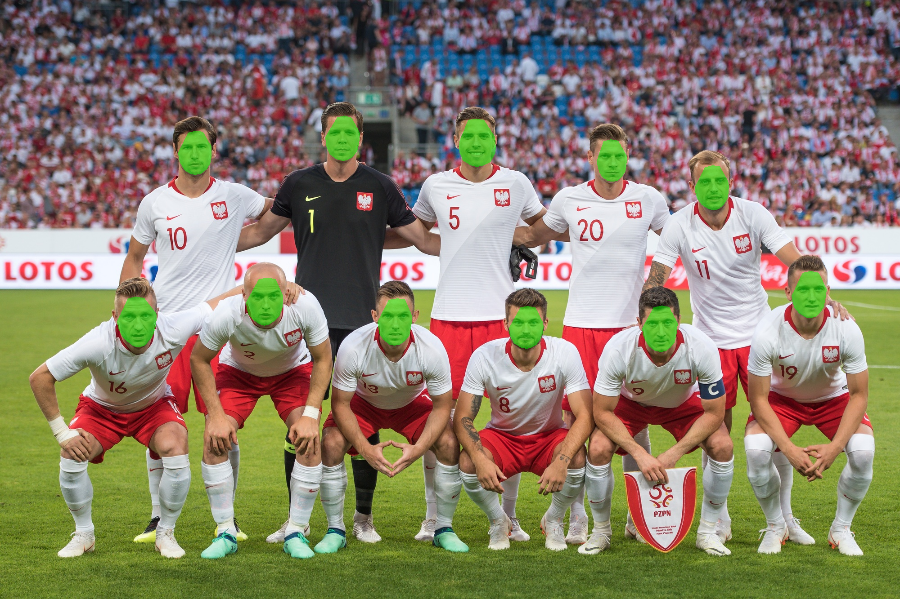

Number of detected faces in image 1: 11


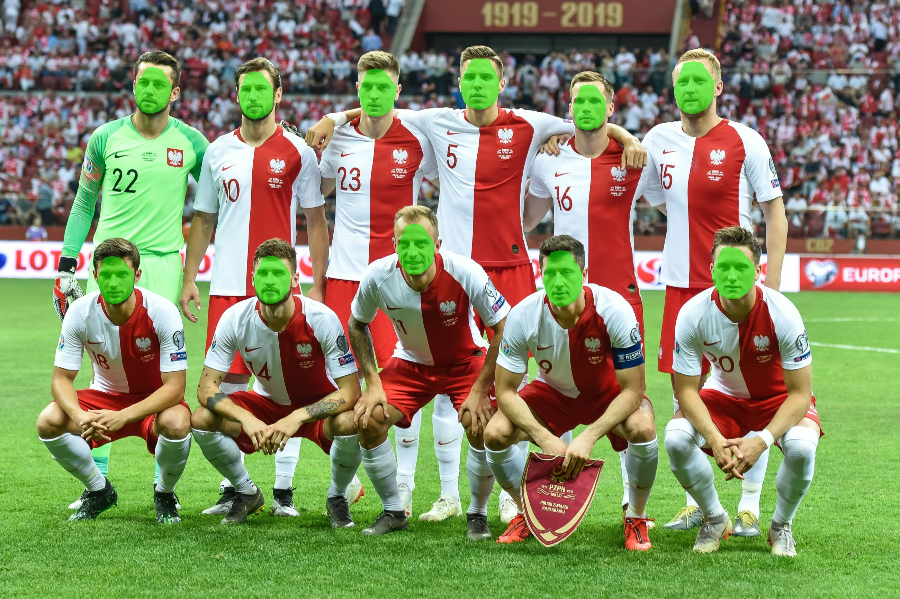

Number of detected faces in image 2: 11


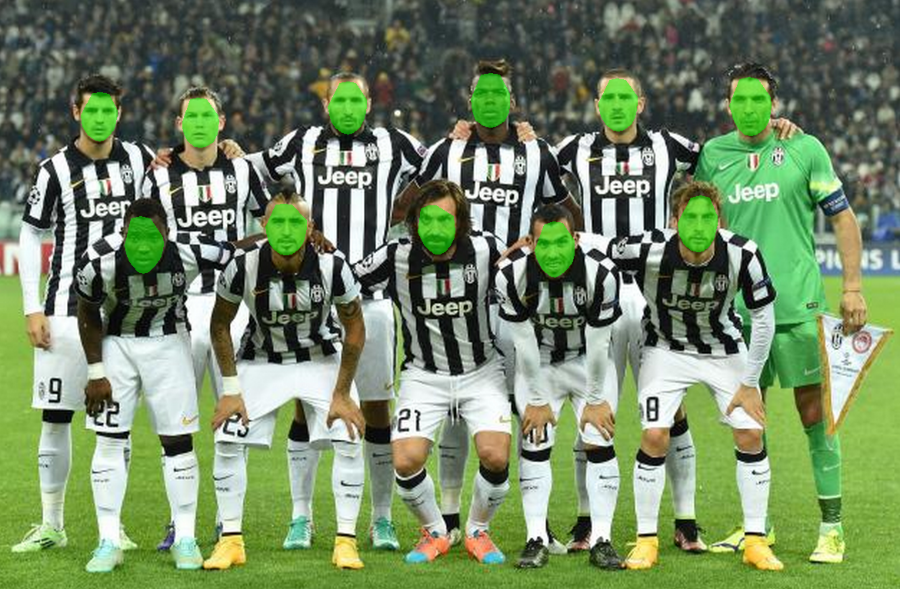

In [ ]:
for idx, img in enumerate(imgs[0:3]):
  face_number, mod_img = count_and_color_faces(img)
  print(f"Number of detected faces in image {idx}: {face_number}")
  display_img(mod_img, tgt_width=900)